# **Part 2 | Multi-Factor Analysis**
*An Analysis of Fama and French 5 Faktor Model with Momentum and ESG Factor*

In [1]:
pip install great_tables -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 607.2/607.2 kB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.9 MB/s eta 0:00:00


In [2]:
#General Imports
import pandas as pd
import numpy as np
import os
import warnings
import ast #Used to read list of stocks in string as a list

#Plotting
from matplotlib.ticker import FuncFormatter, PercentFormatter
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, DateFormatter
from matplotlib import cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from great_tables import GT, md, style, loc

#Working with Data
from functools import reduce #Get Monthly Data
from datetime import datetime, timedelta
import datetime as dt
from pandas.tseries.offsets import MonthEnd

#Estimation
import statsmodels.api as sm #Regression
from scipy import stats #Correlation
from scipy.stats import kendalltau, spearmanr, pearsonr #Kendal Tau
from scipy.stats import ttest_1samp

#Other Stuff
from IPython.display import display, Markdown  # For Markdown rendering

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

## **1. Data Collection**

### **1.1 Import ESG Data**

#### **1.11 Import ESG Factor**

In [3]:
esg_data = pd.read_csv("__data/esg_factor.csv", delimiter = ",") #Importing ESG Factor Data

In [4]:
esg_data_subsetted = esg_data.rename(columns={"Average_Return_High": "return_high_esg", "Average_Return_Low": "return_low_esg"})
esg_data_subsetted = esg_data_subsetted[["Date", "return_high_esg", "return_low_esg", "ESG_Factor"]]

esg_data_subsetted["Date"] = pd.to_datetime(esg_data["Date"])
esg_data_subsetted['Date'] = esg_data_subsetted["Date"].dt.date

In [5]:
esg_data.head()

,Date,Average_Return_High,Count_High,MCap_Total_High,MCap_Average_High,Avg_ESG_Score_High,Average_Return_Low,Count_Low,MCap_Total_Low,MCap_Average_Low,Avg_ESG_Score_Low,ESG_Factor,ESG_Factor_Residual
0,2009-12-31,0.038894,154,6110.540896,39.678837,70.750223,0.057903,154,908.712776,6.017965,18.733658,0.019009,-0.010181
1,2010-01-31,-0.033412,156,5988.273673,38.386370,70.962015,-0.030241,156,912.673663,5.965187,18.795111,0.003171,0.005373
2,2010-02-28,0.043410,156,6176.713433,39.594317,70.951422,0.054302,156,963.517698,6.297501,18.802700,0.010892,0.005079
3,2010-03-31,0.069097,156,6533.051561,41.878536,70.999618,0.070676,156,1005.762128,6.573609,18.795148,0.001579,-0.006843
4,2010-04-30,0.025750,156,6633.206082,42.520552,70.952922,0.045017,156,1022.315223,6.681799,18.983957,0.019267,0.000317


### **1.2 Importing Single Stock Data**

In [6]:
#Imports Stock Returns
stock_returns = pd.read_excel("__data/Stock_Return_Data_Wide_Format.xlsx", "ReturnTotal")

In [7]:
#Divides Stock Return values by 100 to get decimal values
stock_returns.loc[:, stock_returns.columns != "Date"] = stock_returns.loc[:, stock_returns.columns != "Date"].apply(lambda x: x / 100)
#stock_returns = stock_returns.loc[:, stock_returns.count() >= 190]

In [8]:
stock_returns["Date"] = pd.to_datetime(stock_returns["Date"])

In [9]:
stock_returns.tail()

,Date,A.N,AA.N,AAL.OQ,AAON.OQ,AAP.N,AAPL.OQ,AAT.N,ABBV.N,ABCB.N,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
185,2024-06-30,-0.005981,-0.101423,-0.014783,0.163717,-0.103482,0.095553,0.044880,0.063756,0.011011,...,-0.063574,0.113823,-0.036164,-0.055398,-0.010918,-0.044437,0.039902,0.004168,0.022411,-0.061003
186,2024-07-31,0.092844,-0.169432,-0.060900,0.014787,0.003973,0.054411,0.184987,0.090424,0.239588,...,0.083879,0.141101,0.002793,0.025984,0.136795,-0.130245,-0.110415,0.191377,0.041036,0.104082
187,2024-08-31,0.010750,-0.025335,-0.001880,0.078843,-0.284541,0.032345,0.027526,0.059303,0.012153,...,-0.024909,0.423419,0.020794,0.036911,-0.016544,0.020677,-0.129401,-0.032311,0.019162,0.001645
188,2024-09-30,0.038903,0.201869,0.058380,0.130130,-0.139484,0.017467,-0.006791,0.005960,0.014766,...,0.017609,0.094090,0.035503,-0.062966,0.072210,-0.004297,0.043478,-0.047215,0.064799,0.108233
189,2024-10-31,-0.120960,0.041676,0.192171,0.059162,-0.078540,-0.030429,0.008608,0.040698,-0.006411,...,-0.141847,0.109837,-0.061198,-0.009541,0.031459,-0.049116,0.070736,0.102499,-0.082752,0.004452


### **1.4 Importing Momentum Factor Data**

In [10]:
mom = pd.read_csv("__data/F-F_Momentum_Factor.CSV", index_col = 0)

# Convert the index to datetime
mom.index = pd.to_datetime(mom.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
mom.columns = mom.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in mom.columns:
    mom[col] = pd.to_numeric(mom[col], errors='coerce')
    mom[col] = mom[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-01-01
mom = mom[mom.index >= '2009-01-01']

# Create a new "Date" column from the index
mom["Date"] = mom.index
mom['Date'] = mom["Date"].dt.date

mom["MOM"] = mom["Mom"]

mom = mom[["Date", "MOM"]]
mom.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
mom.head()

,Date,MOM
0,2009-01-31,-0.0218
1,2009-02-28,0.0441
2,2009-03-31,-0.1187
3,2009-04-30,-0.3430
4,2009-05-31,-0.1249


### **1.5 Importing Fama and French Data**

In [11]:
ff5 = pd.read_csv("__data/F-F_Research_Data_5_Factors_2x3.csv", skiprows=3, index_col=0)

# Convert the index to datetime
ff5.index = pd.to_datetime(ff5.index, format='%Y%m') + MonthEnd(0)

# Remove any potential whitespace in column names
ff5.columns = ff5.columns.str.strip()

# Convert data to numeric, replacing any non-numeric values with NaN
for col in ff5.columns:
    ff5[col] = pd.to_numeric(ff5[col], errors='coerce')
    ff5[col] = ff5[col] / 100 #Divide by 100 to get actual "returns" as decimals

# Drop observations older than 2009-01-01
ff5 = ff5[ff5.index >= '2009-01-01']

# Create a new "Date" column from the index
ff5["Date"] = ff5.index
ff5['Date'] = ff5["Date"].dt.date

# Sort columns and drop index
ff5 = ff5[['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']]
ff5.reset_index(drop=True, inplace=True)

# Display the first few rows of the resulting dataframe
ff5.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
184,2024-05-31,0.0434,0.0076,-0.0166,0.0298,-0.0307,0.0044
185,2024-06-30,0.0277,-0.0437,-0.0331,0.0051,-0.0178,0.0041
186,2024-07-31,0.0124,0.0828,0.0573,0.0022,0.0043,0.0045
187,2024-08-31,0.0161,-0.0365,-0.0113,0.0085,0.0086,0.0048
188,2024-09-30,0.0174,-0.0103,-0.0260,0.0003,-0.0026,0.0040


### **1.6 Merging Data**

In [12]:
# Merge all datasets on the Date column
dataframes = [ff5, mom, esg_data_subsetted, stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

# Display the first few rows and column names of the resulting dataframe
data.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,return_high_esg,return_low_esg,...,YETI.N,YOU.N,YUM.N,ZBH.N,ZBRA.OQ,ZD.OQ,ZI.OQ,ZION.OQ,ZTS.N,ZWS.N
169,2024-01-31,0.0070,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,-0.017469,-0.035805,...,-0.150830,-0.078450,-0.008955,0.032046,-0.123587,0.003125,-0.132504,-0.044905,-0.046279,0.008160
170,2024-02-29,0.0507,-0.0076,-0.0352,-0.0198,-0.0216,0.0042,0.0498,0.034943,0.048457,...,-0.066636,0.016588,0.074310,-0.009873,0.166688,0.020178,0.044888,-0.049404,0.056014,0.073592
171,2024-03-31,0.0283,-0.0118,0.0421,0.0147,0.0119,0.0043,-0.0040,0.048524,0.030862,...,-0.060673,0.121910,0.001662,0.063194,0.078574,-0.083188,-0.043556,0.100685,-0.146826,0.054173
172,2024-04-30,-0.0467,-0.0256,-0.0052,0.0148,-0.0030,0.0047,-0.0042,-0.046839,-0.066778,...,-0.073411,-0.178655,0.018752,-0.088650,0.043524,-0.205108,-0.010605,-0.060369,-0.056266,-0.065432
173,2024-05-31,0.0434,0.0076,-0.0166,0.0298,-0.0307,0.0044,-0.0002,0.034909,0.057064,...,0.140538,-0.033200,-0.022308,-0.042650,-0.007057,0.149671,-0.225725,0.068726,0.064808,0.003421


In [13]:
#Len data
len(data)

174

## **2 Visualizing Factors**

### **2.1 Return Distributions**

In [14]:
def plotXReturnDistributions(data_list, column_names, labels, colors, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.kdeplot(data[column_name], color = colors[i], label = labels[i], fill = False, alpha = 0.35)

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG data**

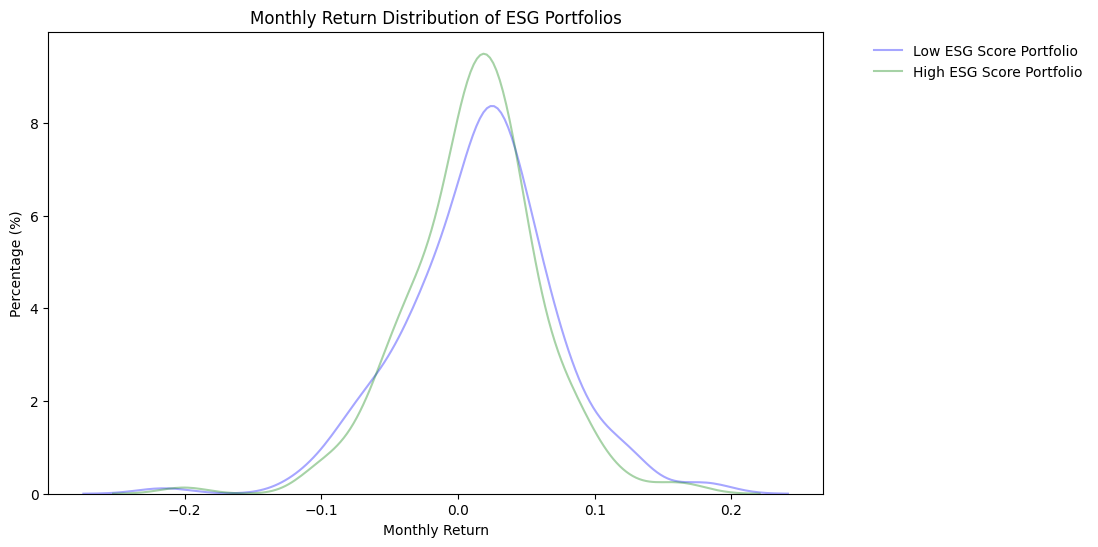

In [15]:
data_list = [data, data]
column_names = ["return_low_esg", "return_high_esg"]
labels = ["Low ESG Score Portfolio", "High ESG Score Portfolio"]
colors = ["blue", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of ESG Portfolios",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

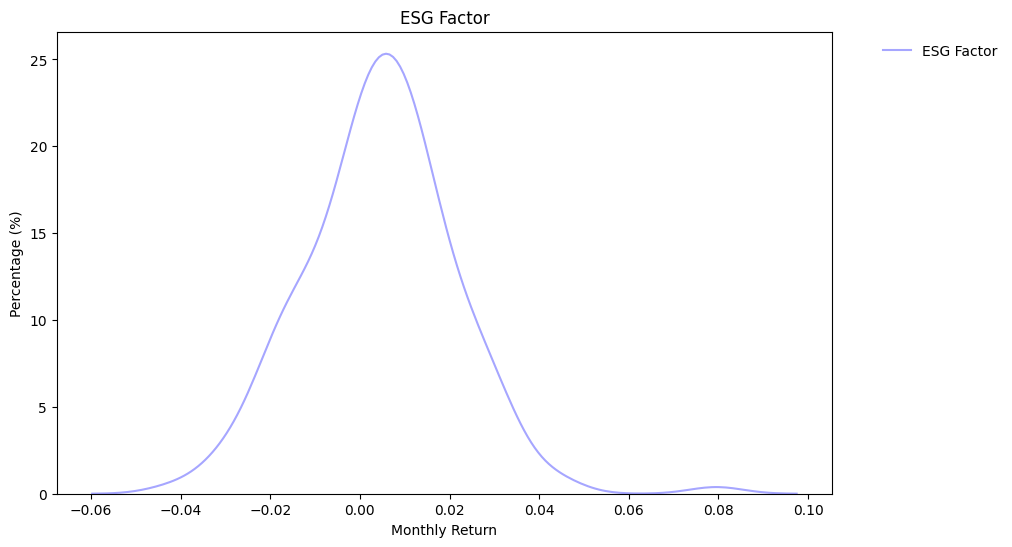

In [16]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "ESG Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

**Fama French 5 Factors + Momentum**

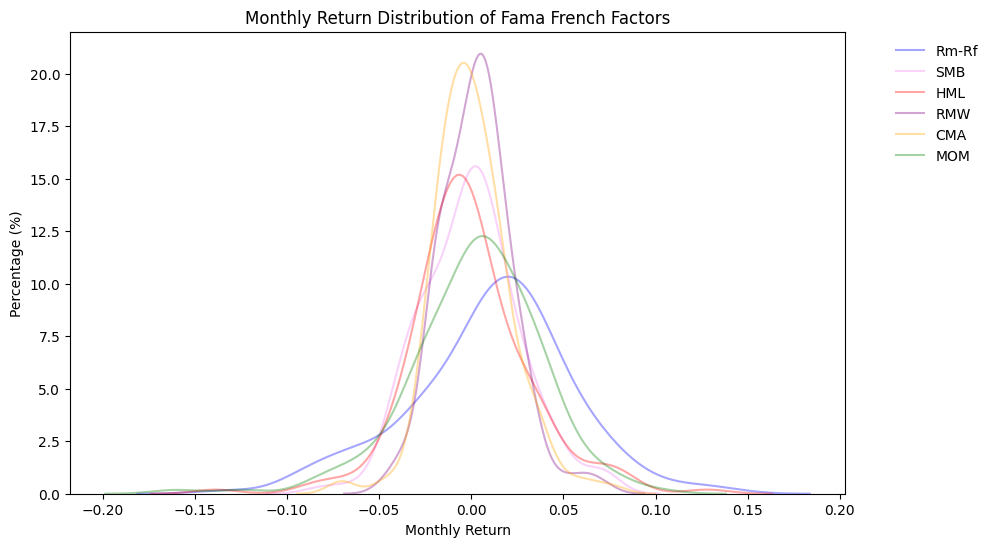

In [17]:
data_list = [data, data, data, data, data, data]

column_names = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM"]
labels = ["Rm-Rf", "SMB", "HML", "RMW", "CMA", "MOM"]
colors = ["blue", "violet", "red", "purple", "orange", "green"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Return Distribution of Fama French Factors",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

### **2.2 Returns over Time**

In [18]:
def plotXReturnsOverTime(data_list, column_names, labels, title, x_label, y_label):

  plt.figure(figsize=(10, 6), dpi=100)

  for i in range(len(column_names)):
    data = data_list[i]
    column_name = column_names[i]

    sns.lineplot(data = data, x = "Date", y = column_name, label = labels[i])

  # Add labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Add legend
  plt.legend(bbox_to_anchor = (1.05, 1), loc = "upper left", frameon = False)

  # Remove Grid
  plt.grid(visible = False)

  # Show plot
  plt.show()

**ESG Factor**

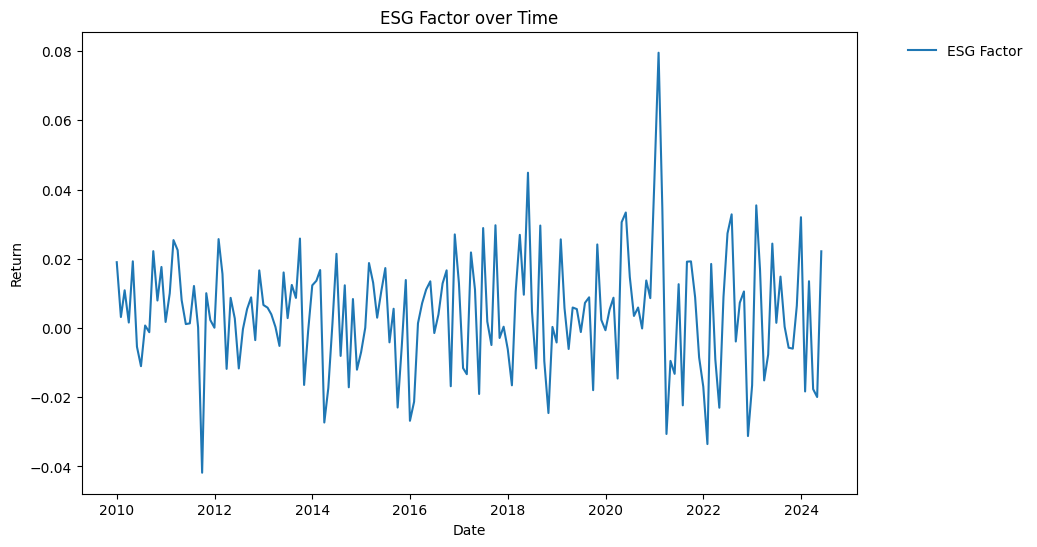

In [19]:
data_list = [data]
column_names = ["ESG_Factor"]
labels = ["ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "ESG Factor over Time", "Date", "Return")

**Momentum & ESG Factor**

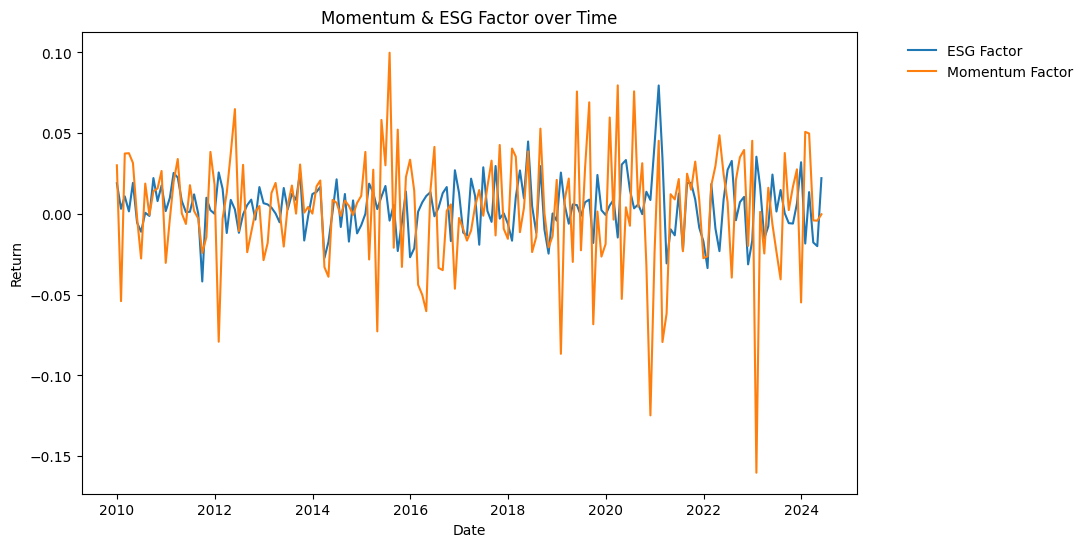

In [20]:
data_list = [data, data]
column_names = ["ESG_Factor", "MOM"]
labels = ["ESG Factor", "Momentum Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "Momentum & ESG Factor over Time", "Date", "Return")


## **3 Visualizing Correlation with Heatmap**

### **3.1 Plotting Functions**

In [21]:
def plotHeatmap(corr_matrix, title):
  plt.figure(figsize=(12, 10))

  #Plot Heatmap
  sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1, center = 0, fmt='.2f')

  # Move x-axis to top
  plt.gca().xaxis.set_ticks_position('top')
  plt.gca().xaxis.set_label_position('top')

  #Rotate labels on X-Axis
  plt.xticks(rotation = 60)

  #Add title
  plt.title(title)
  plt.show()

In [22]:
#Calculating Correlation Coefficients
factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM", "ESG_Factor"]

#Columns of dataframes
columns = data[factor_columns].columns

### **3.2 Calculate & Plot Pearson Correlation Coefficient**

In [23]:
#Correlation & P-Value Matrices
corr_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix_pearson = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:

        #Calculates correlation coefficient and p-value
        corr, pval = pearsonr(data[col1], data[col2])

        #Adds values to dataframes
        corr_matrix_pearson.loc[col1, col2] = corr
        pval_matrix_pearson.loc[col1, col2] = pval

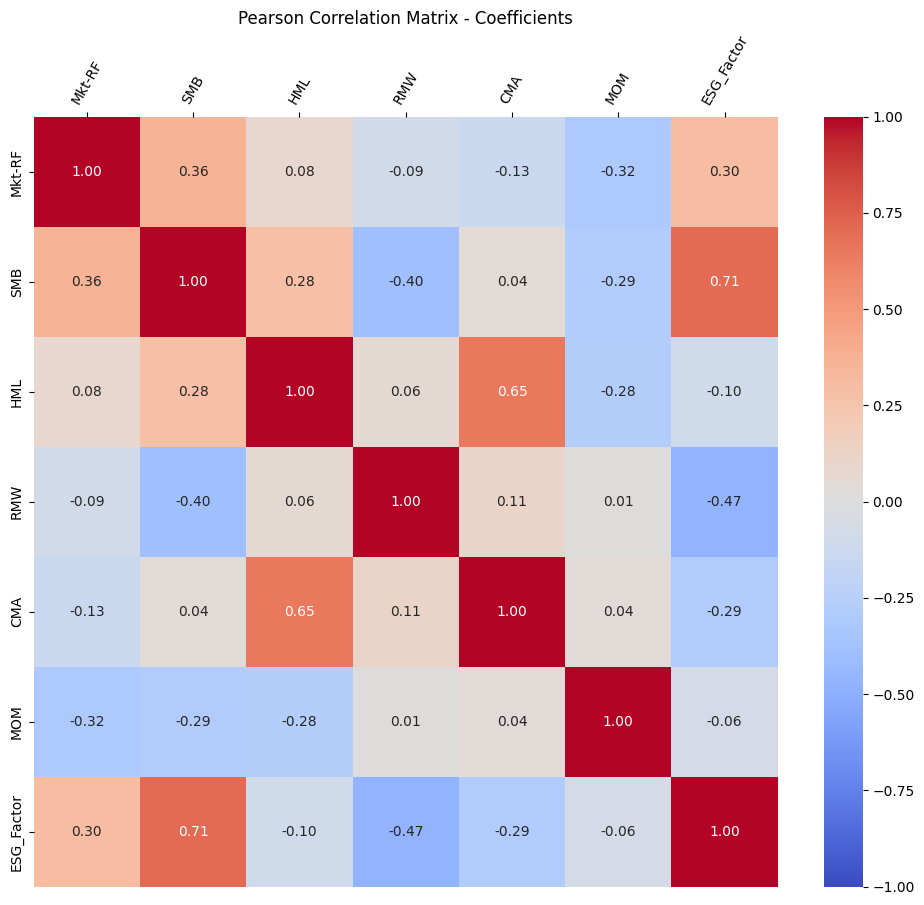

In [24]:
plotHeatmap(corr_matrix_pearson, "Pearson Correlation Matrix - Coefficients")

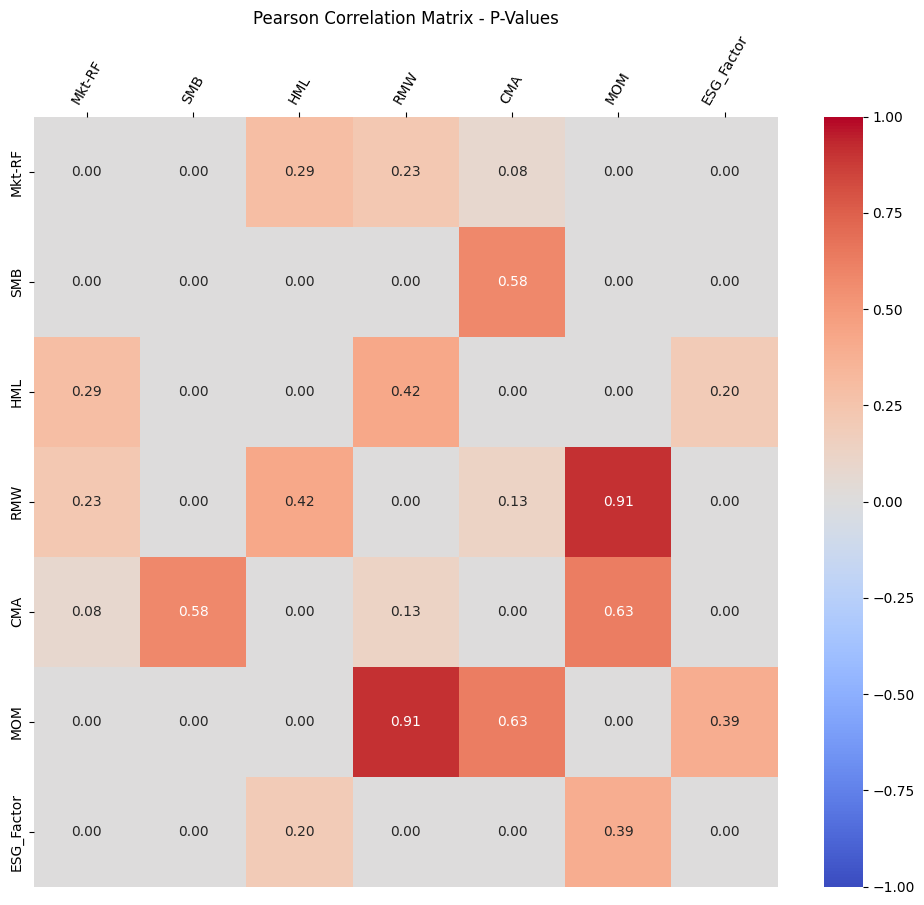

In [25]:
plotHeatmap(pval_matrix_pearson, "Pearson Correlation Matrix - P-Values")

### **3.3 Calculate & Plot Spearman Rank Correlation**

In [26]:
#Correlation & P-Value Matrices
corr_matrix_spearman = pd.DataFrame(index=columns, columns=columns, dtype=float)
pval_matrix_spearman = pd.DataFrame(index=columns, columns=columns, dtype=float)

for col1 in columns:
    for col2 in columns:

        #Calculates correlation coefficient and p-value
        corr, pval = spearmanr(data[col1], data[col2])

        #Adds values to dataframes
        corr_matrix_spearman.loc[col1, col2] = corr
        pval_matrix_spearman.loc[col1, col2] = pval

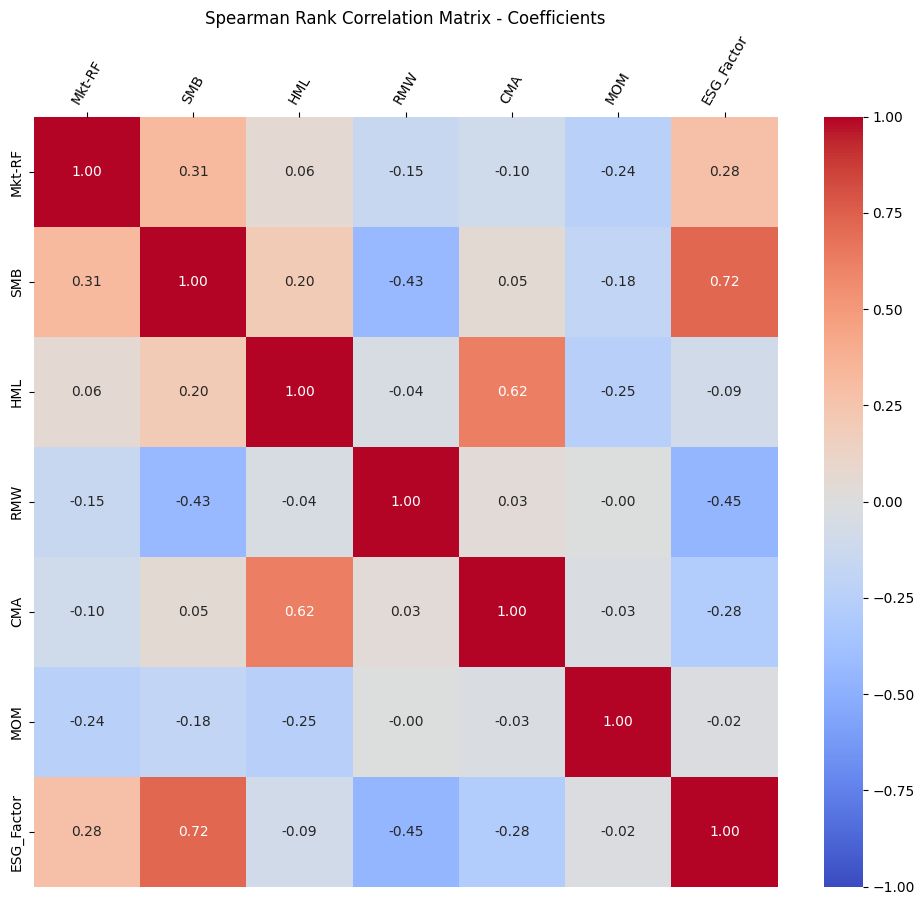

In [27]:
plotHeatmap(corr_matrix_spearman, "Spearman Rank Correlation Matrix - Coefficients")

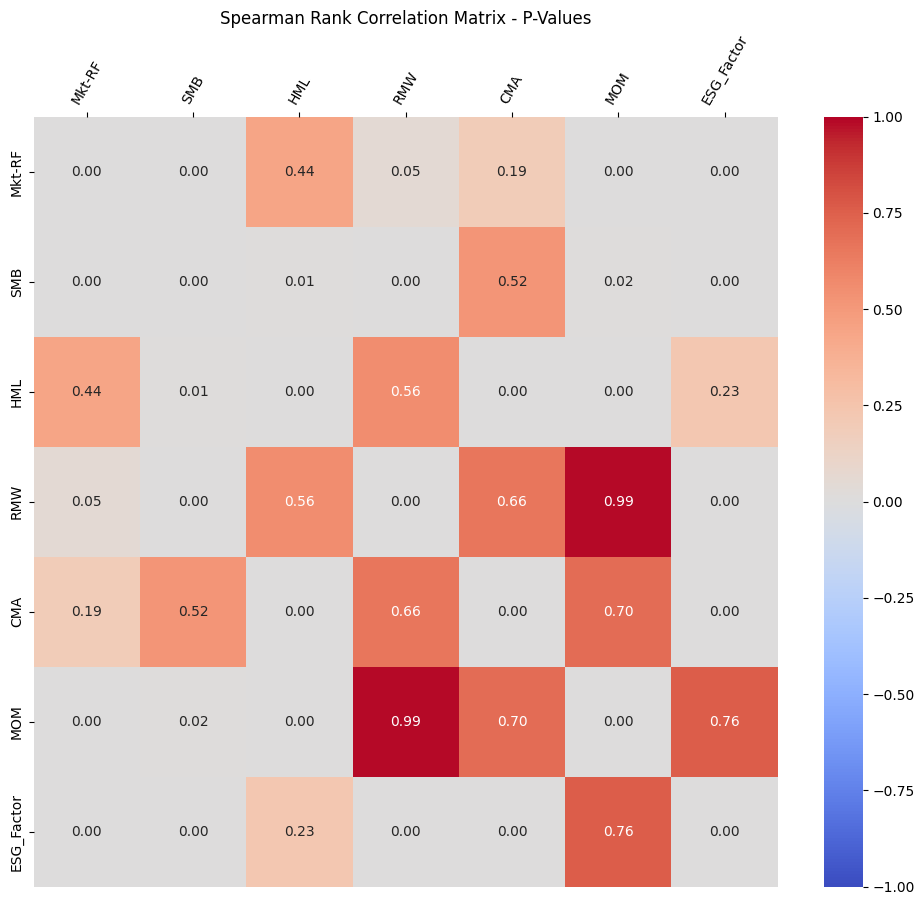

In [28]:
plotHeatmap(pval_matrix_spearman, "Spearman Rank Correlation Matrix - P-Values")

### **3.3 Calculate & Plot Kendall Tau**

In [29]:
n_cols = len(factor_columns)

#Initialize empty matrix
kendall_corr_matrix = np.zeros((n_cols, n_cols))
kendall_pval_matrix = np.zeros((n_cols, n_cols))

#Counting variable for rows
row = 0

#Loop over all coefficients
for factor_1 in factor_columns:

  #Counting variable for column
  column = 0

  #Loop over all coefficients again
  for factor_2 in factor_columns:

    #Calculate Kendall Tau Correlation
    tau, pval = kendalltau(data[factor_1], data[factor_2])

    kendall_corr_matrix[row, column] = tau
    kendall_pval_matrix[row, column] = pval

    column = column + 1

  row = row + 1

#Convert to a DataFrame for easier plotting
kendall_tau_df = pd.DataFrame(kendall_corr_matrix, columns = factor_columns, index = factor_columns)
kendall_pval_df = pd.DataFrame(kendall_pval_matrix, columns = factor_columns, index = factor_columns)

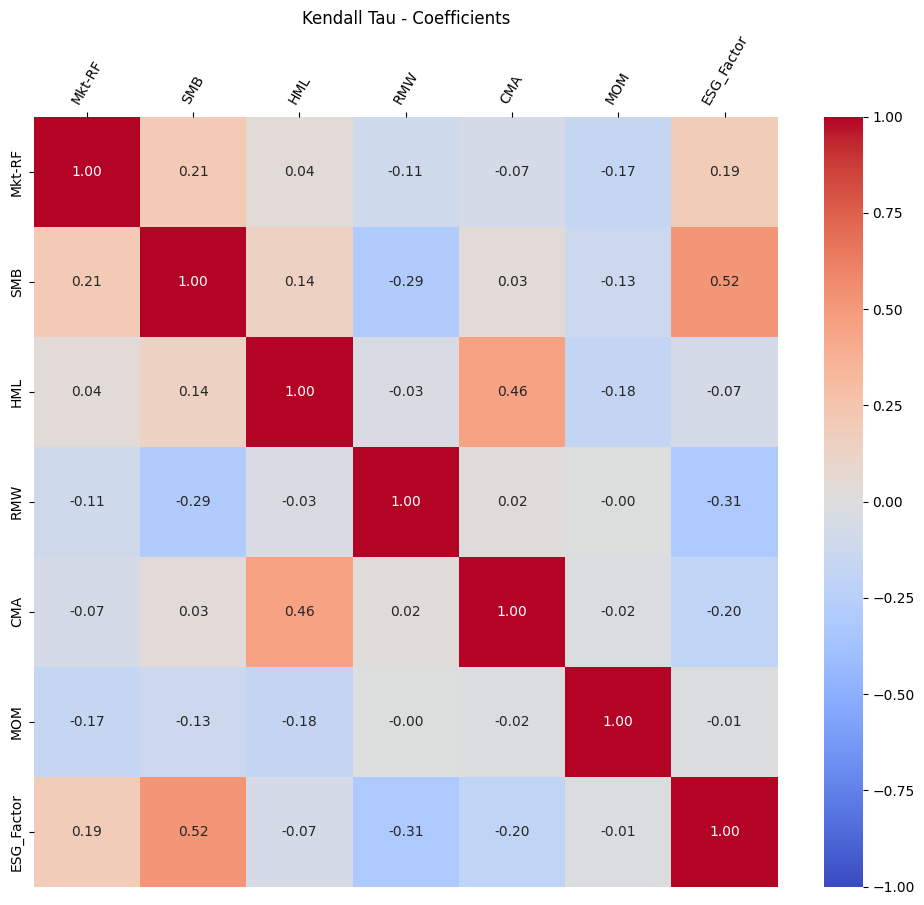

In [30]:
plotHeatmap(kendall_tau_df, "Kendall Tau - Coefficients") #rank-based relationships

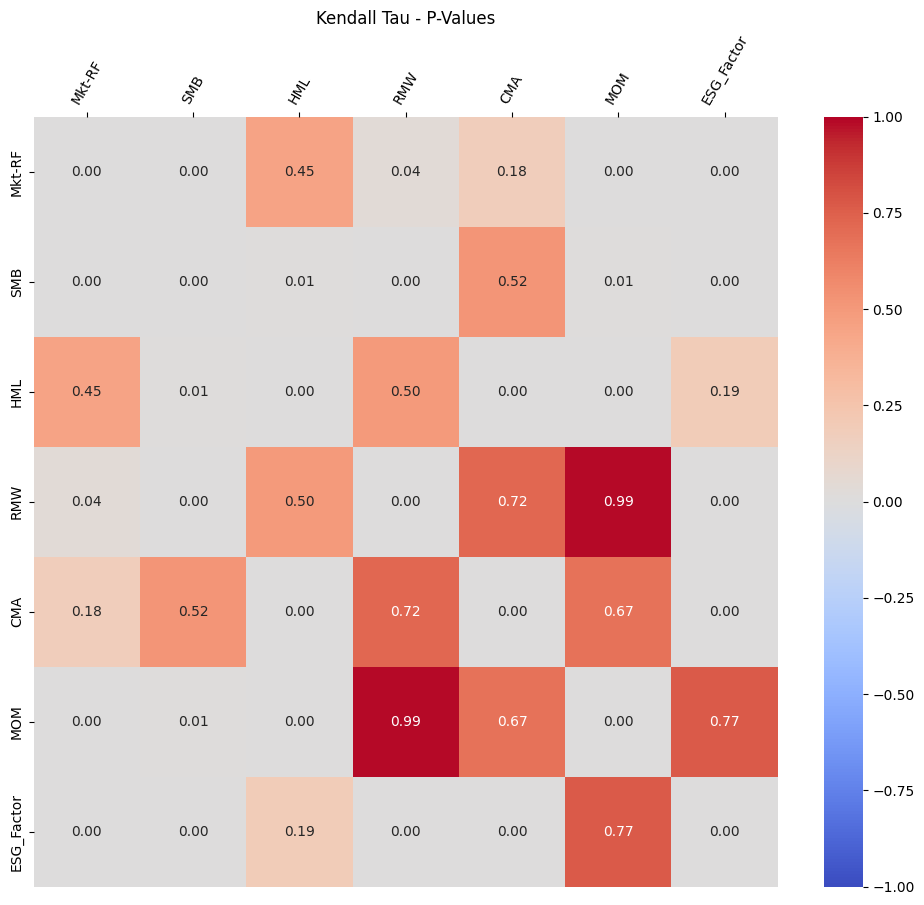

In [31]:
plotHeatmap(kendall_pval_df, "Kendall Tau - P-Values") #rank-based relationships

## **4. Fama-Macbeth Regression with Regular ESG Factor**

### **4.1 Regression Functions**

In [32]:
def getFactorColumns(exclude = []):

  factors = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM", "ESG_Factor"]

  if exclude != []:
    filtered_factors = [factor for factor in factors if factor not in exclude]

    return filtered_factors
  else:
    return factors

  #return ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM"]

In [33]:
def getStocks(regression_data):
  factor_columns = getFactorColumns()

  stocks = [col for col in regression_data.columns if col not in (factor_columns
                                                                  + ["RF"]
                                                                  + ["return_high_esg", "return_low_esg", "Date"])]
  return stocks

In [34]:
def runFirstStageRegression(reg_data, exclude = []):

  stocks = getStocks(reg_data)
  factor_columns = getFactorColumns(exclude)

  #Stocks are all columns except
  betas = pd.DataFrame(columns=["Stock", "Intercept"] + factor_columns)

  #Run Regression
  for stock in stocks:
    #Drop missing values
    current_stock_data = reg_data[["RF"] + factor_columns + [stock]].dropna()

    #Make sure regression is only done if there are at least 32 data-points.

    if len(current_stock_data) >= 32:
      Y = current_stock_data[stock] - current_stock_data["RF"] #Computes Excess Return
      X = current_stock_data[factor_columns] #Sets Factors
      X = sm.add_constant(X) #Adds constant to model

      model = sm.OLS(Y, X).fit() #Runs regression

      coefficients = model.params #Gets betas
      row = [stock] + coefficients.tolist()

      betas.loc[len(betas)] = row #Add betas

  return betas

In [35]:
def runSecondStageRegressionMonthly(models_betas, regression_data, exclude = []):
  risk_premium_estimations = []

  #Gets list of stocks
  stocks = getStocks(regression_data)

  #Filters regression data to only include the stock returns and transposes it to long format
  return_data = regression_data[["Date"] + stocks]
  return_data_transposed = return_data.melt(id_vars = "Date", var_name = "Stock", value_name = "Return")

  risk_premium_data = []

  stage_2_data = models_betas
  stage_2_factor_columns = getFactorColumns(exclude)

  #I run this regression for each date in the date column
  for date in regression_data["Date"]:

    current_return_data = return_data_transposed[return_data_transposed["Date"] == date].dropna()
    current_return_data = current_return_data[["Stock", "Return"]]

    stage_2_data = models_betas.merge(current_return_data, on = "Stock")

    stage_2_Y = stage_2_data["Return"] #Computes Excess Return
    stage_2_X = stage_2_data[stage_2_factor_columns]
    stage_2_X = sm.add_constant(stage_2_X) #Adds constant to model

    stage_2_model = sm.OLS(stage_2_Y, stage_2_X).fit(cov_type='HC3') #Runs regression with Heteroskedasticity robust std. errors

    risk_premium = stage_2_model.params

    risk_premium_now = {"Date": date.date()}
    risk_premium_now.update(risk_premium.to_dict())
    risk_premium_data.append(risk_premium_now)

  return pd.DataFrame(risk_premium_data)

In [58]:
#This functions runs a regression on a constant to obtain average values and p-values
def obtainAverageRiskPremiaAndPValues(risk_premium_estimations):
  current_factors = []
  current_risk_premia = []
  current_p_values = []
  current_t_statistics = []

  for factor in risk_premium_estimations.columns:
    if factor != "Date":

      y = risk_premium_estimations[factor]
      X = sm.add_constant(pd.Series(1, index = y.index))

      model = sm.OLS(y, X).fit()

      current_factors.append(f"{factor}")
      current_risk_premia.append(round(model.params[0] * 100, 4))
      current_p_values.append(model.pvalues[0])
      current_t_statistics.append(model.tvalues[0])

  current_factor_data = pd.DataFrame({
    "Factor": current_factors,
    "Coefficient": current_risk_premia,
    "P-Value": current_p_values,
    "T-Statistic": current_t_statistics
  })

  return current_factor_data

### **4.2 Plotting Table Functions**

In [37]:
def cleanUpRegressionResults(results):

  results.rename(columns={"Coefficient": "Monthly RP"}, inplace = True)
  #results["Annualized RP"] = round(results["Monthly RP"] * 12, 2)

  results["P-Value"] = round(results["P-Value"], 4)
  results["T-Statistic"] = round(results["T-Statistic"], 2)

  #results = results[["Factor", "Monthly RP", "Annualized RP", "P-Value"]]
  results = results[["Factor", "Monthly RP", "P-Value", "T-Statistic"]]

  return results

In [38]:
def getNiceTable(data, title, subtitle):
  nice_table = (
    GT(data)

    .tab_header(
        title = title,
        subtitle = subtitle,
    )
  )

  return nice_table

### **4.3 Run Regressions**

In [59]:
#Copy Data for Regression to prevent altering original Data
regression_data = data.copy()

#### **4.31 Entire Period**

**RFM-7**

In [60]:
#Run Regressions
models_betas_1 = runFirstStageRegression(regression_data)
risk_premium_estimations_1 = runSecondStageRegressionMonthly(models_betas_1, regression_data)
result_1 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_1)

#Create Table
cleaned_up_results_1 = cleanUpRegressionResults(result_1)
monthly_risk_premium_table_1 = getNiceTable(cleaned_up_results_1, "Risk Premium (ESG Factor)", "")

#Print Table
monthly_risk_premium_table_1

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      0.7209   0.0005         3.57
1      Mkt-RF      0.7593   0.0549         1.93
2         SMB      0.2681   0.2362         1.19
3         HML     -0.5500   0.0487        -1.99
4         RMW     -0.2101   0.2612        -1.13
5         CMA     -0.3553   0.0838        -1.74
6         MOM      0.6419   0.0562         1.92
7  ESG_Factor      0.3985   0.0161         2.43, _body=<great_tables._gt_data.Body object at 0x7cef74821490>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef74985990>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef748e0090>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_col

**RFM-5**

In [61]:
#Run Regressions
models_betas_2 = runFirstStageRegression(regression_data, ["RMW", "CMA"])
risk_premium_estimations_2 = runSecondStageRegressionMonthly(models_betas_2, regression_data, ["RMW", "CMA"])
result_2 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_2)

#Create Table
cleaned_up_results_2 = cleanUpRegressionResults(result_2)
monthly_risk_premium_table_2 = getNiceTable(cleaned_up_results_2, "Risk Premium (ESG Factor)", "")

#Print Table
monthly_risk_premium_table_2

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      0.6899   0.0009         3.37
1      Mkt-RF      0.7866   0.0500         1.97
2         SMB      0.2672   0.2543         1.14
3         HML     -0.5573   0.0463        -2.01
4         MOM      0.5943   0.0818         1.75
5  ESG_Factor      0.3744   0.0580         1.91, _body=<great_tables._gt_data.Body object at 0x7cef748a95d0>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef74b08850>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef74860650>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_c

#### **4.32 Until 12/2019**

In [62]:
regression_data_subsetted = regression_data[regression_data["Date"] <= "2019-12-31"]

**RFM-7**

In [63]:
#Run Regressions
models_betas_3 = runFirstStageRegression(regression_data_subsetted)
risk_premium_estimations_3 = runSecondStageRegressionMonthly(models_betas_3, regression_data_subsetted)
result_3 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_3)

#Create Table
cleaned_up_results_3 = cleanUpRegressionResults(result_3)
monthly_risk_premium_table_3 = getNiceTable(cleaned_up_results_3, "Risk Premium (ESG Factor)", "")

#Print Table
monthly_risk_premium_table_3

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      1.0699   0.0000         5.91
1      Mkt-RF      0.3589   0.3574         0.92
2         SMB      0.3135   0.1682         1.39
3         HML     -0.5312   0.0180        -2.40
4         RMW     -0.1329   0.3727        -0.89
5         CMA     -0.3482   0.0203        -2.35
6         MOM      0.8730   0.0076         2.72
7  ESG_Factor      0.3218   0.0229         2.30, _body=<great_tables._gt_data.Body object at 0x7cef748615d0>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef7480c690>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef747af350>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_col

**RFM-5**

In [64]:
#Run Regressions
models_betas_4 = runFirstStageRegression(regression_data_subsetted, ["RMW", "CMA"])
risk_premium_estimations_4 = runSecondStageRegressionMonthly(models_betas_4, regression_data_subsetted, ["RMW", "CMA"])
result_4 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_4)

#Create Table
cleaned_up_results_4 = cleanUpRegressionResults(result_4)
monthly_risk_premium_table_4 = getNiceTable(cleaned_up_results_4, "Risk Premium (ESG Factor)", "")

#Print Table
monthly_risk_premium_table_4

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      1.0273   0.0000         5.45
1      Mkt-RF      0.3884   0.3187         1.00
2         SMB      0.3345   0.1462         1.46
3         HML     -0.5394   0.0168        -2.43
4         MOM      0.8633   0.0083         2.68
5  ESG_Factor      0.3277   0.0232         2.30, _body=<great_tables._gt_data.Body object at 0x7cef74540050>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef744c4c90>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef744c5890>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_c

## **5. Market Capitalization Patterns in ESG Portfolios**

All 3 correlation coefficients suggest a higher correlation between ESG and SMB. This could be because the ESG factor is in reality some kind of small cap factor. We thought that maybe small stocks are not able to achieve high ESG scores because they lack the knowledge and money to change their processes accordingly. Therefore, it could be that they systematically have lower ESG scores and are therefore represented in the Low ESG Portfolio while bigger stocks on the other hand are more represented in the High ESG Portfolio. We analyze this in this section to understand if that is true.

### **5.1 Calculate MCap for Portfolios**

In [45]:
esg_data_mcap_analysis = esg_data.copy()

esg_data_mcap_analysis["Date"] = pd.to_datetime(esg_data_mcap_analysis["Date"])
esg_data_mcap_analysis["Date"] = esg_data_mcap_analysis["Date"].dt.date

In [46]:
esg_data_mcap_analysis["Difference_Total"] = esg_data_mcap_analysis["MCap_Total_High"] - esg_data_mcap_analysis["MCap_Total_Low"]
esg_data_mcap_analysis["Difference_Average"] = esg_data_mcap_analysis["MCap_Average_High"] - esg_data_mcap_analysis["MCap_Average_Low"]

In [47]:
esg_data_mcap_analysis.head()

,Date,Average_Return_High,Count_High,MCap_Total_High,MCap_Average_High,Avg_ESG_Score_High,Average_Return_Low,Count_Low,MCap_Total_Low,MCap_Average_Low,Avg_ESG_Score_Low,ESG_Factor,ESG_Factor_Residual,Difference_Total,Difference_Average
0,2009-12-31,0.038894,154,6110.540896,39.678837,70.750223,0.057903,154,908.712776,6.017965,18.733658,0.019009,-0.010181,5201.828119,33.660872
1,2010-01-31,-0.033412,156,5988.273673,38.386370,70.962015,-0.030241,156,912.673663,5.965187,18.795111,0.003171,0.005373,5075.600009,32.421182
2,2010-02-28,0.043410,156,6176.713433,39.594317,70.951422,0.054302,156,963.517698,6.297501,18.802700,0.010892,0.005079,5213.195734,33.296816
3,2010-03-31,0.069097,156,6533.051561,41.878536,70.999618,0.070676,156,1005.762128,6.573609,18.795148,0.001579,-0.006843,5527.289433,35.304927
4,2010-04-30,0.025750,156,6633.206082,42.520552,70.952922,0.045017,156,1022.315223,6.681799,18.983957,0.019267,0.000317,5610.890859,35.838753


### **5.2 Visualize Results**

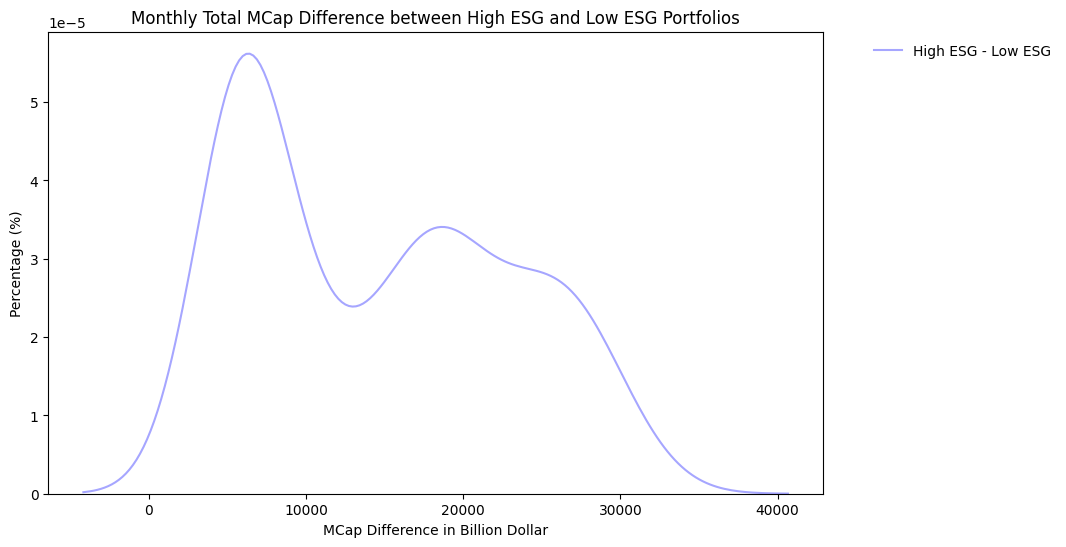

In [48]:
data_list = [esg_data_mcap_analysis]
column_names = ["Difference_Total"]
labels = ["High ESG - Low ESG"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Total MCap Difference between High ESG and Low ESG Portfolios",
                           x_label = "MCap Difference in Billion Dollar",
                           y_label = "Percentage (%)")

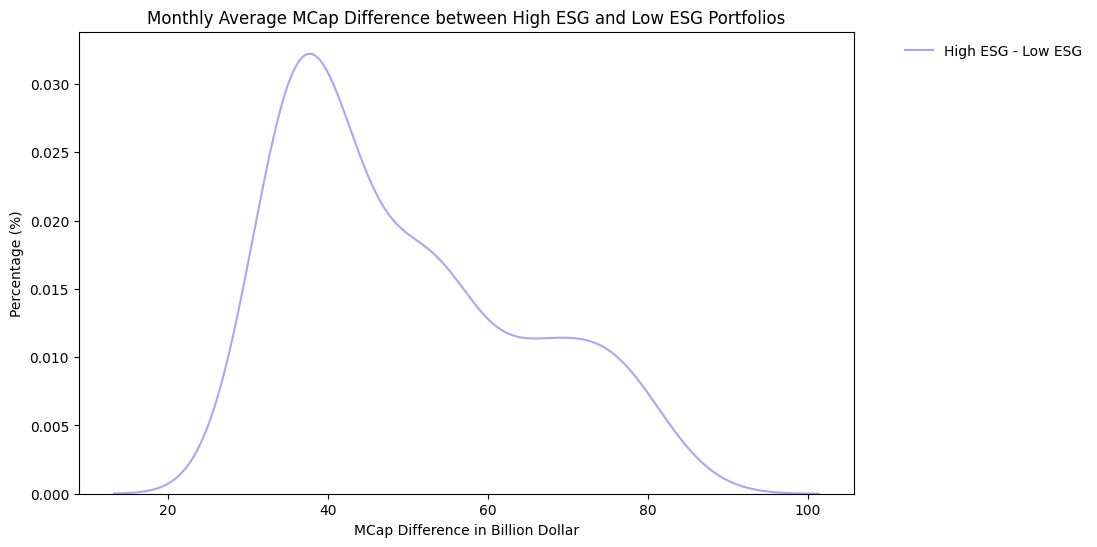

In [49]:
data_list = [esg_data_mcap_analysis]
column_names = ["Difference_Average"]
labels = ["High ESG - Low ESG"]
colors = ["blue"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Average MCap Difference between High ESG and Low ESG Portfolios",
                           x_label = "MCap Difference in Billion Dollar",
                           y_label = "Percentage (%)")

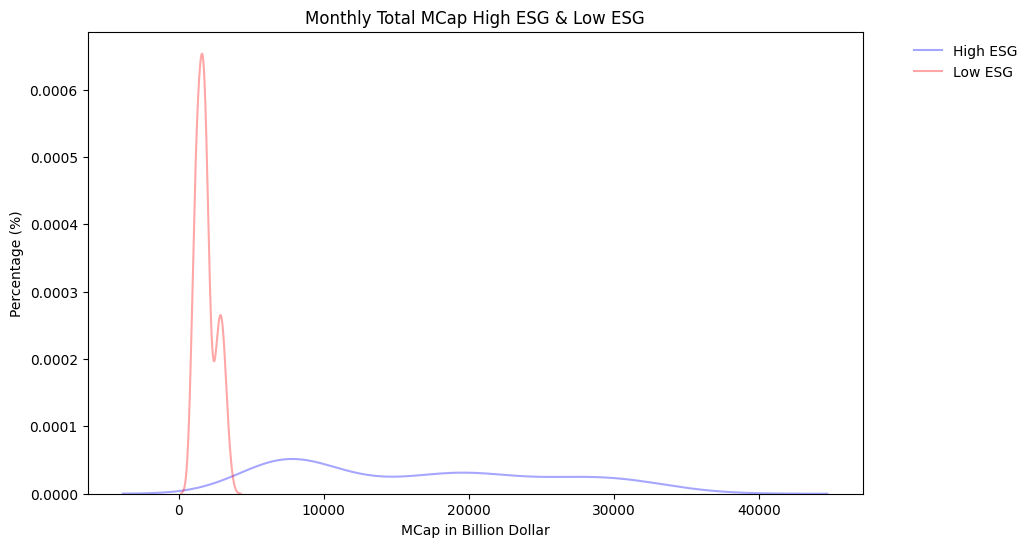

In [50]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["MCap_Total_High", "MCap_Total_Low"]
labels = ["High ESG", "Low ESG"]
colors = ["blue", "red"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "Monthly Total MCap High ESG & Low ESG",
                           x_label = "MCap in Billion Dollar",
                           y_label = "Percentage (%)")

## **6. Fama-MacBeth Regression with Residual ESG Factor**

### **6.1 ESG Factor Analysis**

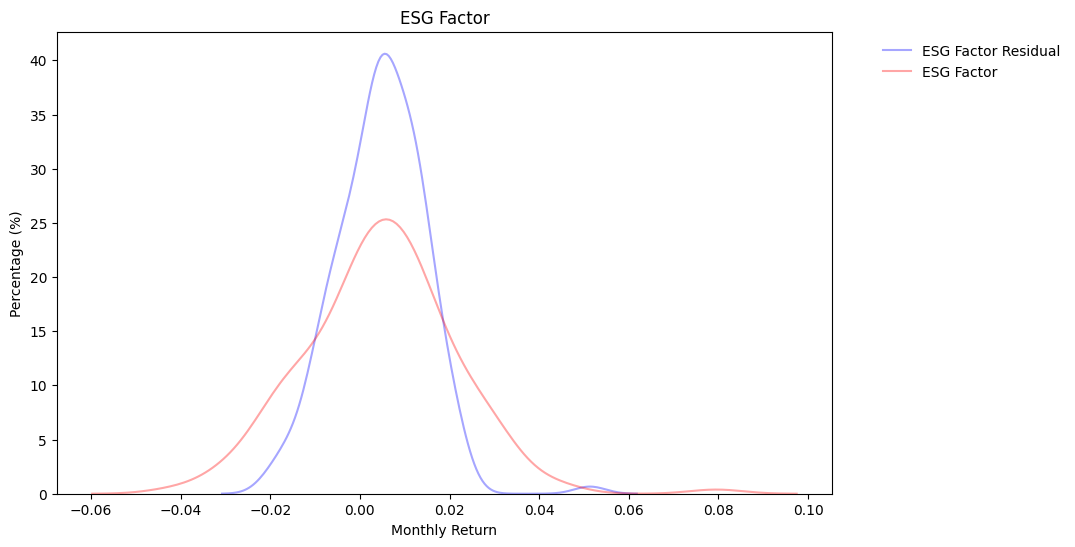

In [65]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["ESG_Factor_Residual", "ESG_Factor"]
labels = ["ESG Factor Residual", "ESG Factor"]
colors = ["blue", "red"]

plotXReturnDistributions(data_list, column_names, labels, colors,
                           title = "ESG Factor",
                           x_label = "Monthly Return",
                           y_label = "Percentage (%)")

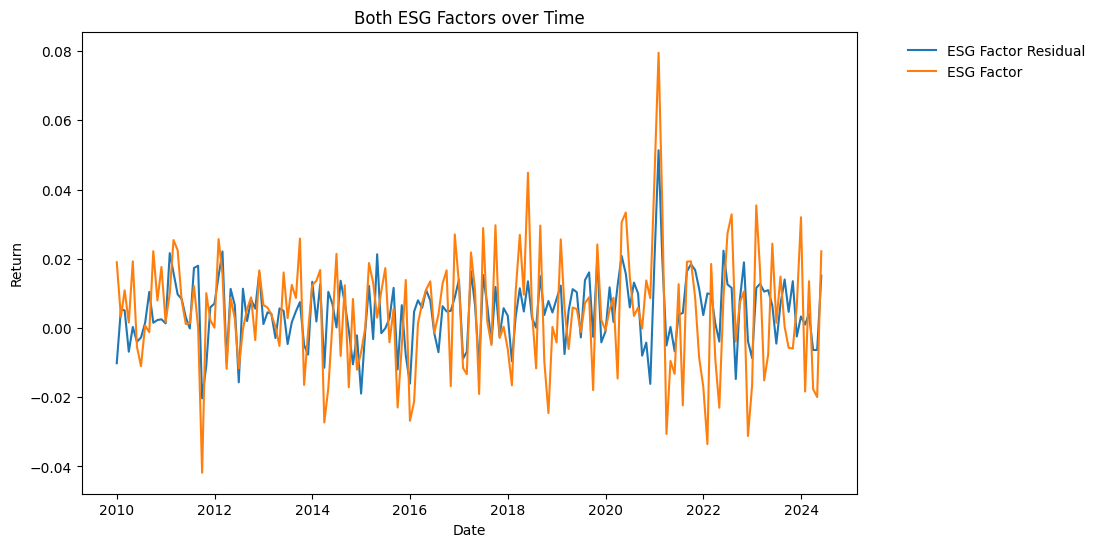

In [66]:
data_list = [esg_data_mcap_analysis, esg_data_mcap_analysis]
column_names = ["ESG_Factor_Residual", "ESG_Factor"]
labels = ["ESG Factor Residual", "ESG Factor"]

plotXReturnsOverTime(data_list, column_names, labels, "Both ESG Factors over Time", "Date", "Return")

### **6.2 Summary Stats & Correlation of Residual ESG Factor & Other Factors Via Heatmap**

#### **6.21 Heatmap**

In [67]:
esg_factors = esg_data_mcap_analysis[["Date", "ESG_Factor", "ESG_Factor_Residual"]]

In [68]:
dataframes = [ff5, mom, esg_factors]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

data_all_esg = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

In [69]:
data_all_esg.tail()

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF,MOM,ESG_Factor,ESG_Factor_Residual
169,2024-01-31,0.0070,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,-0.018336,0.000988
170,2024-02-29,0.0507,-0.0076,-0.0352,-0.0198,-0.0216,0.0042,0.0498,0.013514,0.004150
171,2024-03-31,0.0283,-0.0118,0.0421,0.0147,0.0119,0.0043,-0.0040,-0.017662,-0.006372
172,2024-04-30,-0.0467,-0.0256,-0.0052,0.0148,-0.0030,0.0047,-0.0042,-0.019939,-0.006336
173,2024-05-31,0.0434,0.0076,-0.0166,0.0298,-0.0307,0.0044,-0.0002,0.022154,0.015090


In [70]:
#Calculating Correlation Coefficients

factor_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "MOM", "ESG_Factor", "ESG_Factor_Residual"]

columns_all_esg = data_all_esg[factor_columns].columns

In [71]:
#Correlation & P-Value Matrices
corr_matrix_pearson_all_esg = pd.DataFrame(index=columns_all_esg, columns=columns_all_esg, dtype=float)
pval_matrix_pearson_all_esg = pd.DataFrame(index=columns_all_esg, columns=columns_all_esg, dtype=float)

for col1 in columns_all_esg:
    for col2 in columns_all_esg:

        #If factor 1 = factor 2 then returns given values
        if col1 == col2:
          corr, pval = 1.0, 0.0
        else:

          #Drops missing values
          cleaned_data = data_all_esg[[col1, col2]].dropna()

          #Calculates correlation coefficient and p-value
          corr, pval = pearsonr(cleaned_data[col1], cleaned_data[col2])

        #Adds values to dataframes
        corr_matrix_pearson_all_esg.loc[col1, col2] = corr
        pval_matrix_pearson_all_esg.loc[col1, col2] = pval

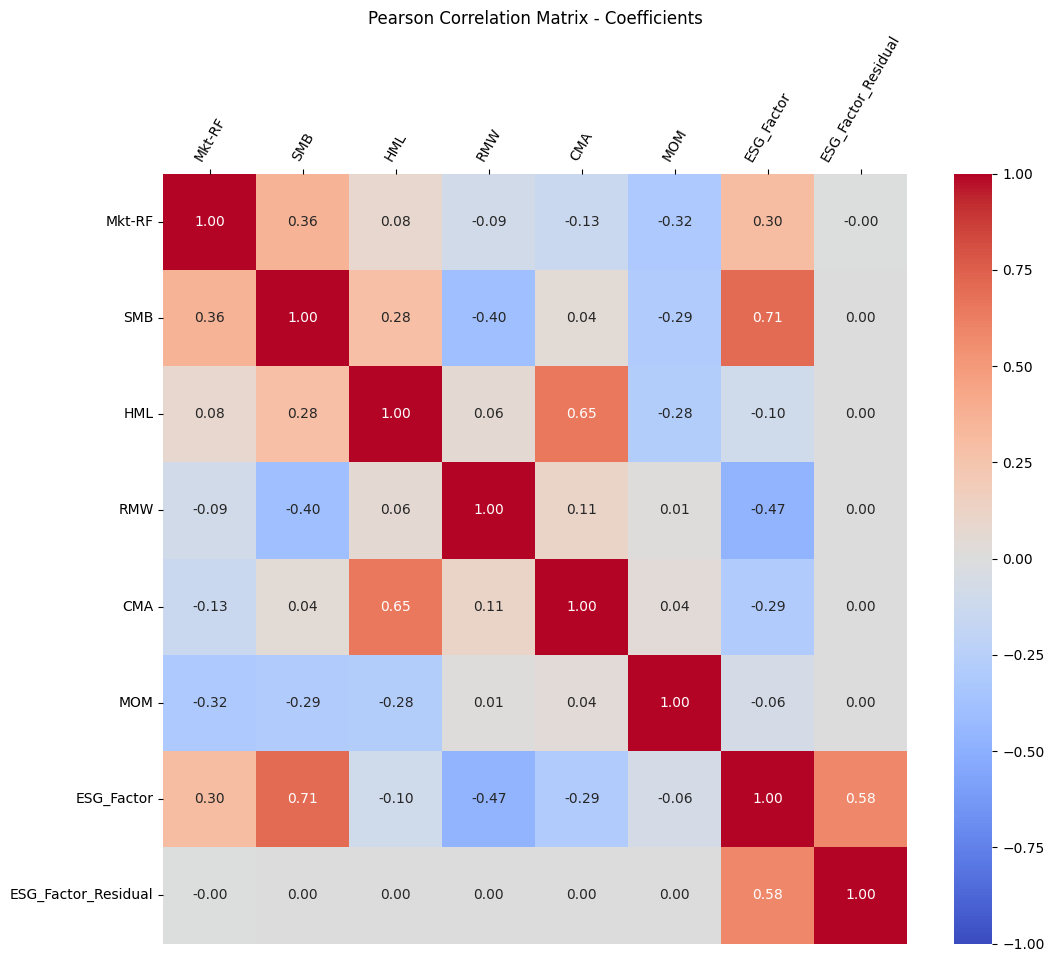

In [72]:
plotHeatmap(corr_matrix_pearson_all_esg, "Pearson Correlation Matrix - Coefficients")

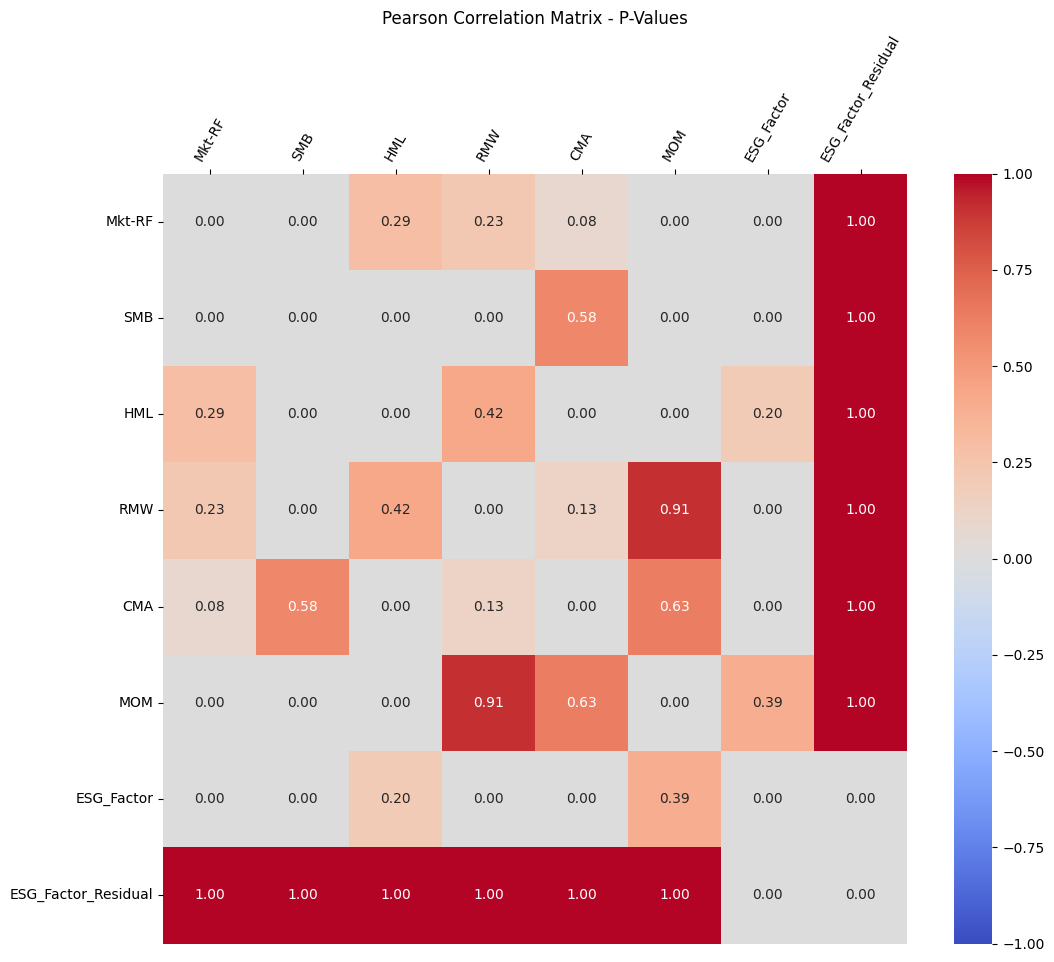

In [73]:
plotHeatmap(pval_matrix_pearson_all_esg, "Pearson Correlation Matrix - P-Values")

#### **6.22 Summary Stats**

In [74]:
def calculate_statistics(data):
    results = []

    for factor in data.columns:

        if factor not in ["Date", "RF"]:

          factor_data = data[factor].dropna()  # Drop NaN values

          mean = factor_data.mean() * 100
          std_dev = factor_data.std() * 100

          # Perform a one-sample t-test with the null hypothesis that the mean is 0
          t_stat, p_value = ttest_1samp(factor_data, 0)

          results.append({"Factor": factor, "Mean": round(mean, 2), "StdDev": round(std_dev, 2), "T-Statistics": round(t_stat, 2), "P-Value": round(p_value, 2)})

    return pd.DataFrame(results)

In [75]:
#Entire period
stats_df = calculate_statistics(data_all_esg)
print(stats_df)

                Factor  Mean  StdDev  T-Statistics  P-Value
0               Mkt-RF  1.08    4.41          3.22     0.00
1                  SMB -0.03    2.70         -0.15     0.88
2                  HML -0.12    3.28         -0.49     0.62
3                  RMW  0.30    1.97          2.04     0.04
4                  CMA  0.04    2.11          0.25     0.80
5                  MOM  0.24    3.59          0.87     0.39
6           ESG_Factor  0.45    1.68          3.56     0.00
7  ESG_Factor_Residual  0.47    0.98          6.34     0.00


In [76]:
#Until December 2021
data_all_esg_subset = data_all_esg[data_all_esg["Date"] <= "2021-12-31"]

stats_df = calculate_statistics(data_all_esg_subset)
print(stats_df)

                Factor  Mean  StdDev  T-Statistics  P-Value
0               Mkt-RF  1.24    4.15          3.61     0.00
1                  SMB  0.06    2.63          0.26     0.79
2                  HML -0.25    2.89         -1.06     0.29
3                  RMW  0.25    1.84          1.60     0.11
4                  CMA  0.02    1.62          0.13     0.90
5                  MOM  0.24    3.45          0.82     0.41
6           ESG_Factor  0.50    1.62          3.71     0.00
7  ESG_Factor_Residual  0.45    0.99          5.50     0.00


In [77]:
#After December 2021
data_all_esg_subset = data_all_esg[data_all_esg["Date"] >= "2021-12-31"]

stats_df = calculate_statistics(data_all_esg_subset)
print(stats_df)

                Factor  Mean  StdDev  T-Statistics  P-Value
0               Mkt-RF  0.34    5.47          0.34     0.74
1                  SMB -0.48    2.97         -0.88     0.38
2                  HML  0.62    4.74          0.72     0.48
3                  RMW  0.74    2.62          1.55     0.13
4                  CMA  0.30    3.74          0.43     0.67
5                  MOM  0.13    4.24          0.17     0.86
6           ESG_Factor  0.16    1.96          0.45     0.66
7  ESG_Factor_Residual  0.54    0.88          3.36     0.00


### **6.3 Merging & Prepping Data for Fama-MacBeth Reg.**

In [78]:
esg_factor_residual = esg_data[["Date", "ESG_Factor_Residual"]]

esg_factor_residual["Date"] = pd.to_datetime(esg_factor_residual["Date"])
esg_factor_residual['Date'] = esg_factor_residual["Date"].dt.date

In [79]:
# Merge all datasets on the Date column
dataframes = [ff5, mom, esg_factor_residual, stock_returns]

for df in dataframes:
    df["Date"] = pd.to_datetime(df["Date"])

#Merge data
data_esg_residual = reduce(lambda left, right: pd.merge(left, right, on = "Date"), dataframes)

#Rename column as requirement for regression functions to work.
data_esg_residual = data_esg_residual.rename(columns = {"ESG_Factor_Residual": "ESG_Factor"})

### **6.4 Run Regressions (Entire Period)**

#### **6.41 Entire Period**

**RFM-7**

In [80]:
#Run Regressions
models_betas_res_esg_1 = runFirstStageRegression(data_esg_residual)
risk_premium_estimations_res_esg_1 = runSecondStageRegressionMonthly(models_betas_res_esg_1, data_esg_residual)
result_res_esg_1 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_res_esg_1)

#Create Table
cleaned_up_results_res_esg_1 = cleanUpRegressionResults(result_res_esg_1)
monthly_risk_premium_table_res_esg_1 = getNiceTable(cleaned_up_results_res_esg_1, "Risk Premium (Residual ESG Factor)", "")

#Print Table
monthly_risk_premium_table_res_esg_1

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      0.7209   0.0005         3.57
1      Mkt-RF      0.7593   0.0549         1.93
2         SMB      0.2681   0.2362         1.19
3         HML     -0.5500   0.0487        -1.99
4         RMW     -0.2101   0.2612        -1.13
5         CMA     -0.3553   0.0838        -1.74
6         MOM      0.6419   0.0562         1.92
7  ESG_Factor      0.0994   0.3578         0.92, _body=<great_tables._gt_data.Body object at 0x7cef74b59490>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef7468b750>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (Residual ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef74879b10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border

**RFM-5**

In [81]:
#Run Regressions
models_betas_res_esg_2 = runFirstStageRegression(data_esg_residual, ["RMW", "CMA"])
risk_premium_estimations_res_esg_2 = runSecondStageRegressionMonthly(models_betas_res_esg_2, data_esg_residual, ["RMW", "CMA"])
result_res_esg_2 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_res_esg_2)

#Create Table
cleaned_up_results_res_esg_2 = cleanUpRegressionResults(result_res_esg_2)
monthly_risk_premium_table_res_esg_2 = getNiceTable(cleaned_up_results_res_esg_2, "Risk Premium (Residual ESG Factor)", "")

#Print Table
monthly_risk_premium_table_res_esg_2

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      0.6497   0.0017         3.19
1      Mkt-RF      0.8117   0.0413         2.06
2         SMB      0.2848   0.2215         1.23
3         HML     -0.5548   0.0463        -2.01
4         MOM      0.6219   0.0664         1.85
5  ESG_Factor      0.0715   0.5615         0.58, _body=<great_tables._gt_data.Body object at 0x7cef74b27390>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef74a11910>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (Residual ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef74c40190>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_bac

#### **6.42 Until 12/2019**

In [82]:
data_esg_residual_subsetted = data_esg_residual[data_esg_residual["Date"] <= "2019-12-31"]

**RFM-7**

In [83]:
#Run Regressions
models_betas_res_esg_3 = runFirstStageRegression(data_esg_residual_subsetted)
risk_premium_estimations_res_esg_3 = runSecondStageRegressionMonthly(models_betas_res_esg_3, data_esg_residual_subsetted)
result_res_esg_3 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_res_esg_3)

#Create Table
cleaned_up_results_res_esg_3 = cleanUpRegressionResults(result_res_esg_3)
monthly_risk_premium_table_res_esg_3 = getNiceTable(cleaned_up_results_res_esg_3, "Risk Premium (Residual ESG Factor)", "")

#Print Table
monthly_risk_premium_table_res_esg_3

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      1.0699   0.0000         5.91
1      Mkt-RF      0.3589   0.3574         0.92
2         SMB      0.3135   0.1682         1.39
3         HML     -0.5312   0.0180        -2.40
4         RMW     -0.1329   0.3727        -0.89
5         CMA     -0.3482   0.0203        -2.35
6         MOM      0.8730   0.0076         2.72
7  ESG_Factor      0.0073   0.9391         0.08, _body=<great_tables._gt_data.Body object at 0x7cef74c50690>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef74641b10>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (Residual ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef746ea850>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border

**RFM-5**

In [84]:
#Run Regressions
models_betas_res_esg_4 = runFirstStageRegression(data_esg_residual_subsetted, ["RMW", "CMA"])
risk_premium_estimations_res_esg_4 = runSecondStageRegressionMonthly(models_betas_res_esg_4, data_esg_residual_subsetted, ["RMW", "CMA"])
result_res_esg_4 = obtainAverageRiskPremiaAndPValues(risk_premium_estimations_res_esg_4)

#Create Table
cleaned_up_results_res_esg_4 = cleanUpRegressionResults(result_res_esg_4)
monthly_risk_premium_table_res_esg_4 = getNiceTable(cleaned_up_results_res_esg_4, "Risk Premium (Residual ESG Factor)", "")

#Print Table
monthly_risk_premium_table_res_esg_4

GT(_tbl_data=       Factor  Monthly RP  P-Value  T-Statistic
0       const      1.0013   0.0000         5.24
1      Mkt-RF      0.4106   0.2922         1.06
2         SMB      0.3405   0.1398         1.49
3         HML     -0.5391   0.0165        -2.43
4         MOM      0.8488   0.0092         2.65
5  ESG_Factor     -0.0068   0.9432        -0.07, _body=<great_tables._gt_data.Body object at 0x7cef74c53950>, _boxhead=Boxhead([ColInfo(var='Factor', type=<ColInfoTypeEnum.default: 1>, column_label='Factor', column_align='left', column_width=None), ColInfo(var='Monthly RP', type=<ColInfoTypeEnum.default: 1>, column_label='Monthly RP', column_align='right', column_width=None), ColInfo(var='P-Value', type=<ColInfoTypeEnum.default: 1>, column_label='P-Value', column_align='right', column_width=None), ColInfo(var='T-Statistic', type=<ColInfoTypeEnum.default: 1>, column_label='T-Statistic', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7cef74641b90>, _spanners=Spanners([]), _heading=Heading(title='Risk Premium (Residual ESG Factor)', subtitle='', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x7cef74c3c3d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_bac